This notebook includes the whole precedure building a logistic regression model, including:
### Step 1: Basic observations on the dataset

### Step 2: Split into training and testing datasets
- (initial thought)To avoid individual bias, we sample investigation instances from each video
  - realize that not every video has enough samples to split into 80%/20%, and also the features from the same video might leak into the test samples
- To avoid order bias, we shuffle all investigation instances and randomly select 20% for the testing dataset
- To avoid scaling bias, we apply Min-Max normalization on the training set and use the same transformation on the test set

### Step 3: Apply logistic regression
- Fit the model with L2 regularization to prevent overfitting
- Use maximum likelihood optimization to learn weights
- Perform grid search over penalty values (10⁻⁴ to 10⁴) using mean cross-validated accuracy for model selection

### Step 4: Evaluate the model
- Accuracy score: Proportion of correct predictions on the test set
- Cross-validation: 3-fold
- F1 score: To account for class imbalance

In [3]:
#import the neccessary python packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
#import some useful functions from sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

#import some plotting packages
import seaborn as sns

### Step 1: Basic observations on the dataset


,sequence,investigation_ID,pair_label,paired,start_frame,end_frame,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed
0,task1/train/mouse001_task1_annotator1,0,0_0,0,1,126,126,198.598475,3312.921155,2.861946,1.435074
1,task1/train/mouse001_task1_annotator1,1,1_0,0,136,633,498,190.933311,3225.591195,2.924218,1.239495
2,task1/train/mouse001_task1_annotator1,2,2_0,0,659,714,56,282.668019,4636.255526,2.938320,1.358593
3,task1/train/mouse001_task1_annotator1,3,3_0,0,736,898,163,144.627995,3110.452149,3.002670,1.198722
4,task1/train/mouse001_task1_annotator1,4,4_0,0,944,1045,102,85.162713,2527.840394,2.714141,1.095686


,investigation_ID,paired,start_frame,end_frame,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed
count,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000
mean,29.082668,0.138590,6273.171587,6344.380688,72.209100,214.888226,4288.664471,2.899996,1.596830
std,28.126639,0.345578,5144.694386,5132.128523,121.178995,147.693160,4517.703255,0.134659,1.036634
min,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000,2.020127,0.000000
25%,8.000000,0.000000,2023.000000,2089.000000,14.000000,121.200877,2729.289495,2.841902,1.060294
50%,20.000000,0.000000,4972.000000,5037.000000,30.000000,181.257655,3621.165274,2.925928,1.380563
75%,42.000000,0.000000,9629.500000,9698.500000,71.500000,268.064152,4843.052367,2.994524,1.826046
max,155.000000,1.000000,23128.000000,23176.000000,1335.000000,3329.574547,197071.767951,3.136071,22.138555


sequence               0
investigation_ID       0
pair_label             0
paired                 0
start_frame            0
end_frame              0
duration               0
mean_speed             0
mean_acc               0
mean_rotation          0
mean_rotation_speed    0
dtype: int64


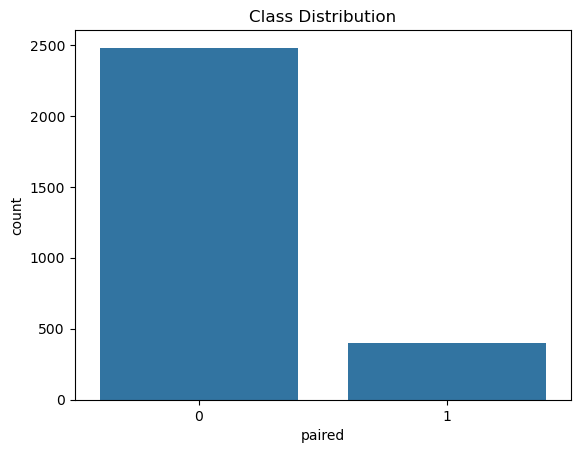

In [53]:
# Load your dataset (adjust path as needed)
df = pd.read_csv(r"G:\My Drive\100-PhD Study\110-Courses\2025Summer_Neuromatch\waffles\Waffle\preprocessed_data\final_df.csv")  # or df = your_dataframe

# Preview data
display(df.head())

# Summary statistics
display(df.describe())

# Check for missing values, just to make sure there's no missing data
print(df.isnull().sum())

# Show a bar plot reflecting the total number of 'paired investigation(1)' VS 'unpaired investigation(0)'
sns.countplot(data=df, x='paired')  
plt.title("Class Distribution")
plt.show()




### Step 2: Split into training and testing datasets
# we want to randomly select 25% investigation event from each video as the test dataset
1. GroupShuffleSplit the videos into the training and testing 
2. Shuffle the investigation bouts within a trianing set to avoid the order bias

In [ ]:
print("Number of unique sequences:", df['sequence'].unique())
#note that 'task1/train/mouse036_task1_annotator1' was dropped after runnning find_I_A_all function the the preprecessed_label_feature notebook

Number of unique sequences: ['task1/train/mouse001_task1_annotator1'
 'task1/train/mouse002_task1_annotator1'
 'task1/train/mouse003_task1_annotator1'
 'task1/train/mouse004_task1_annotator1'
 'task1/train/mouse005_task1_annotator1'
 'task1/train/mouse006_task1_annotator1'
 'task1/train/mouse007_task1_annotator1'
 'task1/train/mouse008_task1_annotator1'
 'task1/train/mouse009_task1_annotator1'
 'task1/train/mouse010_task1_annotator1'
 'task1/train/mouse011_task1_annotator1'
 'task1/train/mouse012_task1_annotator1'
 'task1/train/mouse013_task1_annotator1'
 'task1/train/mouse014_task1_annotator1'
 'task1/train/mouse015_task1_annotator1'
 'task1/train/mouse016_task1_annotator1'
 'task1/train/mouse017_task1_annotator1'
 'task1/train/mouse018_task1_annotator1'
 'task1/train/mouse019_task1_annotator1'
 'task1/train/mouse020_task1_annotator1'
 'task1/train/mouse021_task1_annotator1'
 'task1/train/mouse022_task1_annotator1'
 'task1/train/mouse023_task1_annotator1'
 'task1/train/mouse024_task1_

In [54]:
#reencode the video ID to numbers
# Encode 'sequence' into numeric form
df['sequence_code'] = pd.factorize(df['sequence'])[0]  # or 'video_id'


In [55]:
#drop the non-numeric information
non_numeric =['sequence', 'pair_label','start_frame','end_frame']
df_dropped = df.copy(deep=True)
df_dropped = df_dropped.drop(columns=non_numeric)

In [56]:
df_dropped

,investigation_ID,paired,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed,sequence_code
0,0,0,126,198.598475,3312.921155,2.861946,1.435074,0
1,1,0,498,190.933311,3225.591195,2.924218,1.239495,0
2,2,0,56,282.668019,4636.255526,2.938320,1.358593,0
3,3,0,163,144.627995,3110.452149,3.002670,1.198722,0
4,4,0,102,85.162713,2527.840394,2.714141,1.095686,0
...,...,...,...,...,...,...,...,...
2874,42,0,6,78.476781,3517.480930,3.126484,0.283671,87
2875,43,0,8,117.942193,2651.071566,2.808574,1.378124,87
2876,44,0,13,43.492372,1546.329159,2.936758,0.933984,87
2877,45,0,144,63.153081,1917.414403,3.040754,0.547662,87


In [57]:
#try to write a function to split the dataset until the bounts and paired investigation percentage is similar
best_diff = float('inf')
best_split = None

groups = df_dropped['sequence_code']  # 
labels = df_dropped['paired'].values

for seed in range(1000):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    train_idx, test_idx = next(gss.split(df_dropped, labels, groups=groups))
    
    y_train = labels[train_idx]
    y_test = labels[test_idx]
    
    train_pct = y_train.mean()
    test_pct = y_test.mean()
    
    diff = abs(train_pct - test_pct)
    
    if diff < best_diff:
        best_diff = diff
        best_split = (train_idx, test_idx)
        
    if diff < 0.01:  # stop early if sufficiently close
        break

train_idx, test_idx = best_split
df_train = df_dropped.iloc[train_idx].reset_index(drop=True)
df_test = df_dropped.iloc[test_idx].reset_index(drop=True)


In [59]:
print(seed)

7


In [58]:
#shuffle bouts in trianig set to avoid the order bias
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
x_train = df_train.drop(columns=['paired'])
y_train = df_train['paired']
x_test = df_test.drop(columns=['paired'])
y_test = df_test['paired']

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test) #remember to fit the same transformation to the test datset

In [60]:
# Convert back to DataFrames
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)

# plot the scatter_matrix to :
1. Visualize pairwise relationships between all features
2. Check correlations or patterns
3. Spot outliers or clusters
4. Use color (c) to reflect class labels, e.g. y_train

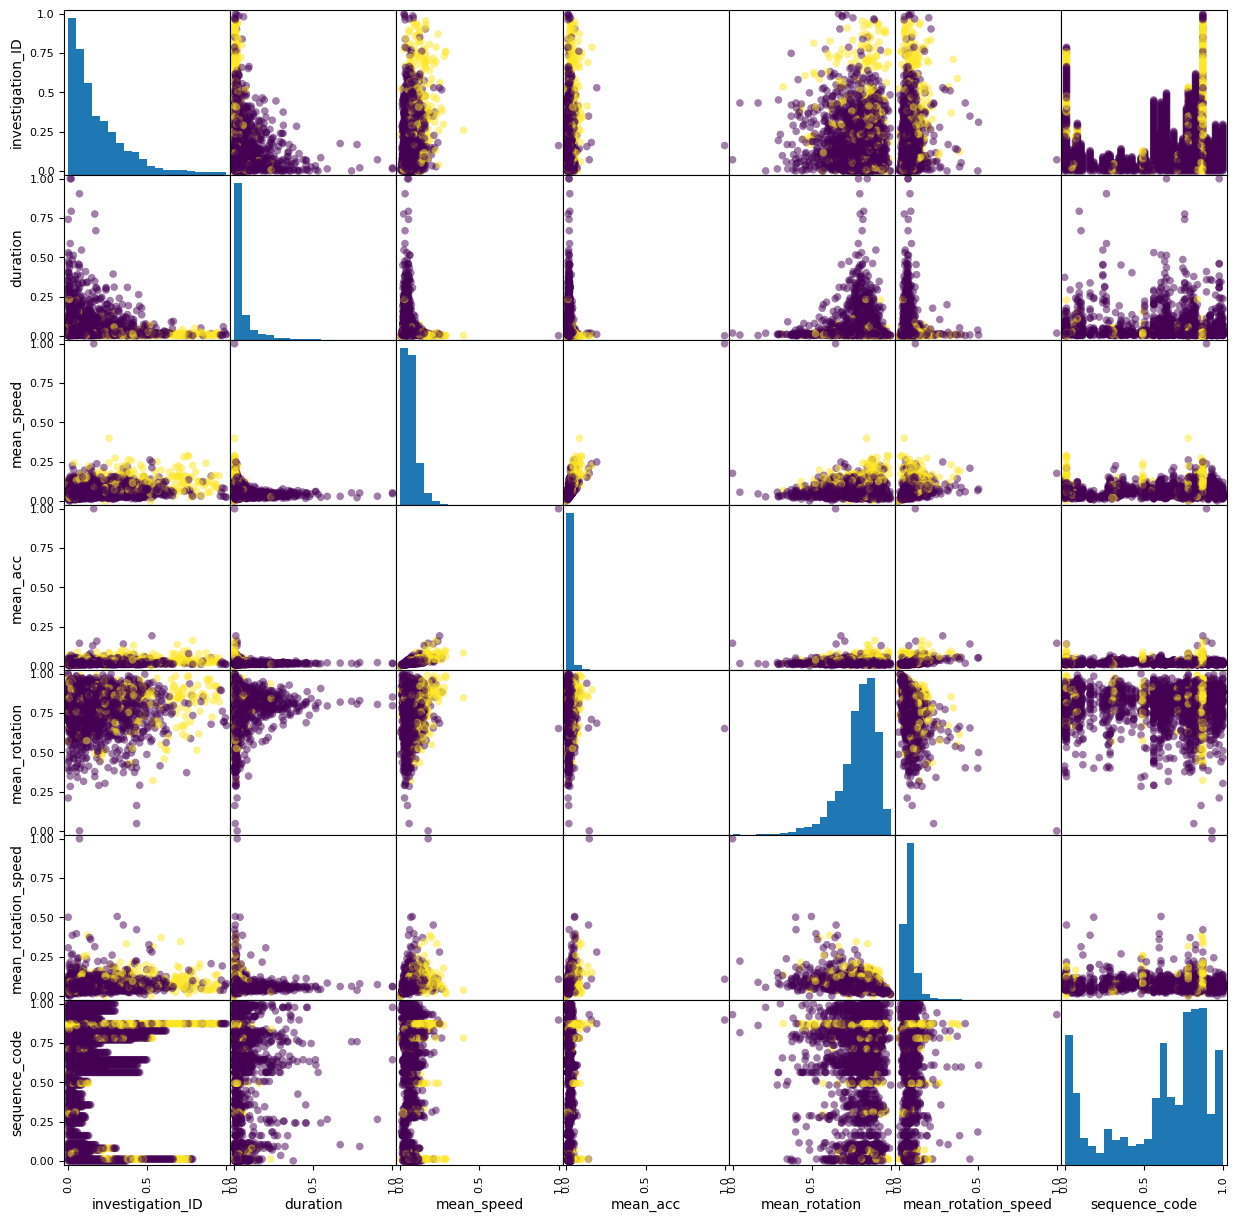

In [61]:
#check the correlation between each features, the distribution of the non-related features like the 
#sequence_code and investigation_ID should be random
grr = pd.plotting.scatter_matrix(x_train_scaled,c=y_train,figsize=(15,15),marker='o',hist_kwds={'bins':20},s=30,alpha=.5)


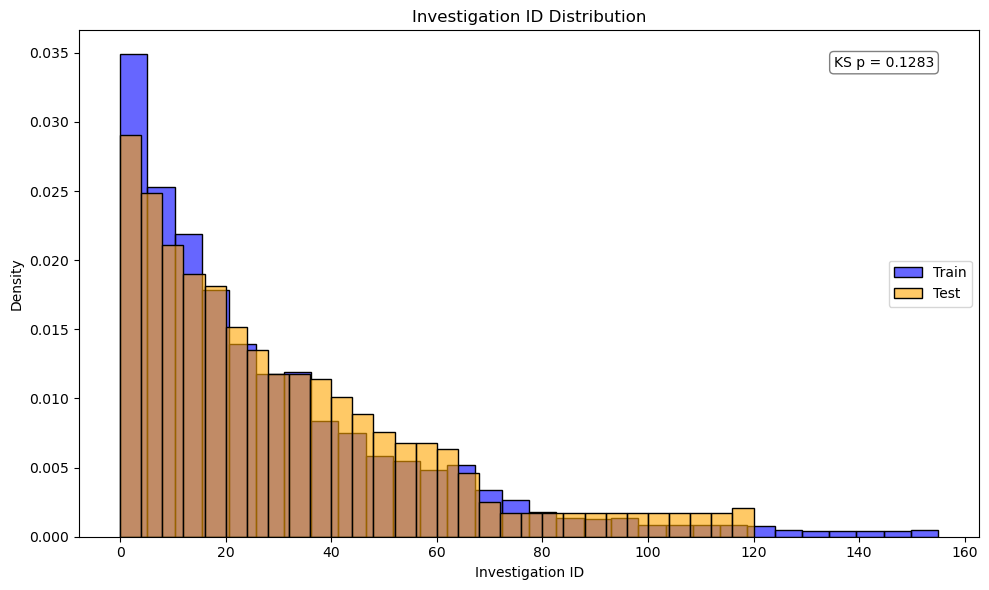

In [62]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_train['investigation_ID'], color='blue', label='Train', bins=30, kde=False, stat='density', alpha=0.6)
sns.histplot(df_test['investigation_ID'], color='orange', label='Test', bins=30, kde=False, stat='density', alpha=0.6)

# KS test
ks_stat, ks_p = ks_2samp(df_train['investigation_ID'], df_test['investigation_ID'])

# Annotate
plt.text(0.95, 0.95, f"KS p = {ks_p:.4f}", transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

plt.title("Investigation ID Distribution")
plt.xlabel("Investigation ID")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


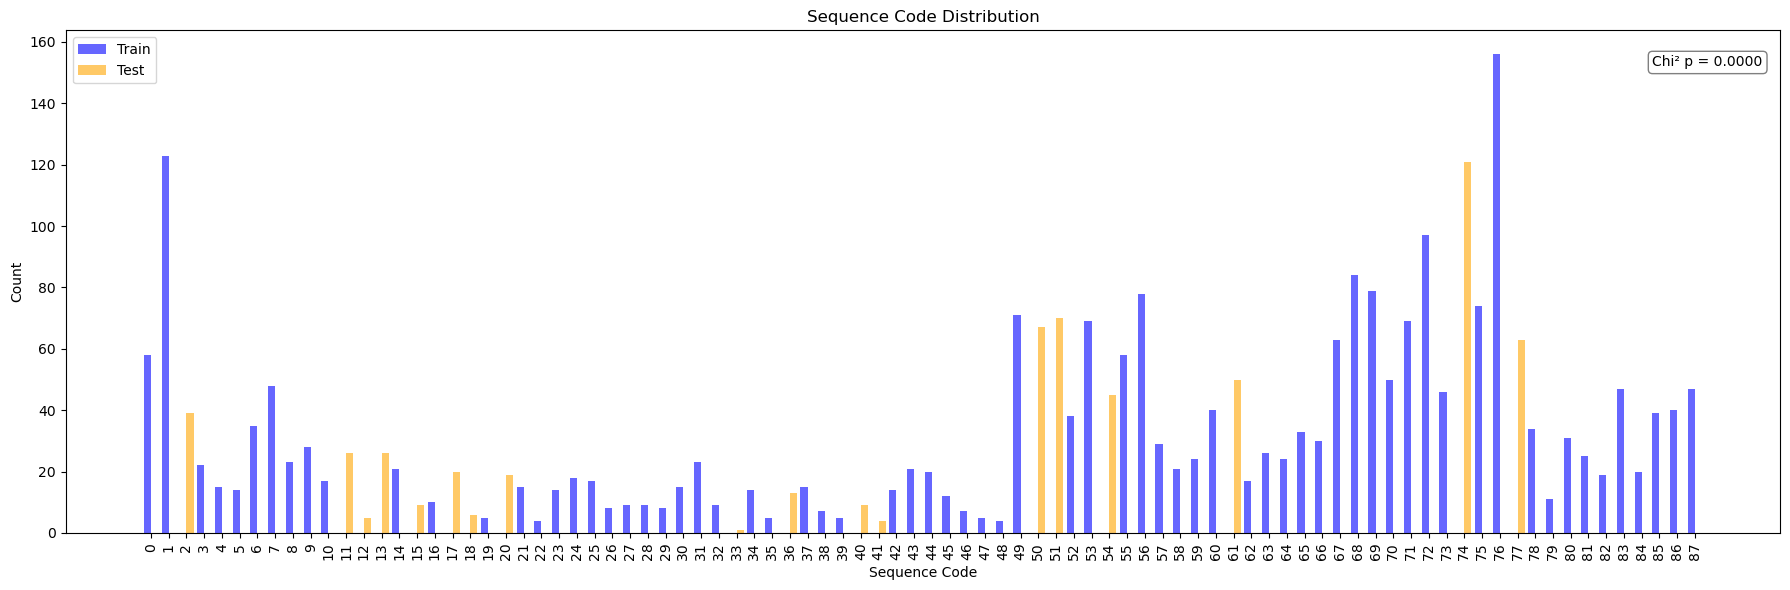

In [63]:
from scipy.stats import chi2_contingency #for categorical variable

# Count occurrences
train_counts = df_train['sequence_code'].value_counts().sort_index()
test_counts = df_test['sequence_code'].value_counts().sort_index()

# Align indices
all_codes = sorted(set(df_train['sequence_code']) | set(df_test['sequence_code']))
train_counts = train_counts.reindex(all_codes, fill_value=0)
test_counts = test_counts.reindex(all_codes, fill_value=0)

# Chi-squared test
contingency = pd.DataFrame({'train': train_counts, 'test': test_counts})
chi2, p_chi, _, _ = chi2_contingency(contingency.T)

# Plot
x = range(len(all_codes))
width = 0.4

plt.figure(figsize=(18, 6))
plt.bar(x, train_counts.values, width=width, label='Train', color='blue', alpha=0.6)
plt.bar([i + width for i in x], test_counts.values, width=width, label='Test', color='orange', alpha=0.6)

# Annotate
plt.text(0.99, 0.95, f"Chi² p = {p_chi:.4f}", transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

plt.xticks([i + width/2 for i in x], all_codes, rotation=90)
plt.title("Sequence Code Distribution")
plt.xlabel("Sequence Code")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\sky\AppData\Local\Temp\ipykernel_20340\842529597.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=bouts_vals, palette=colors, ax=ax[0])
C:\Users\sky\AppData\Local\Temp\ipykernel_20340\842529597.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=paired_pct_vals, palette=colors, ax=ax[1])


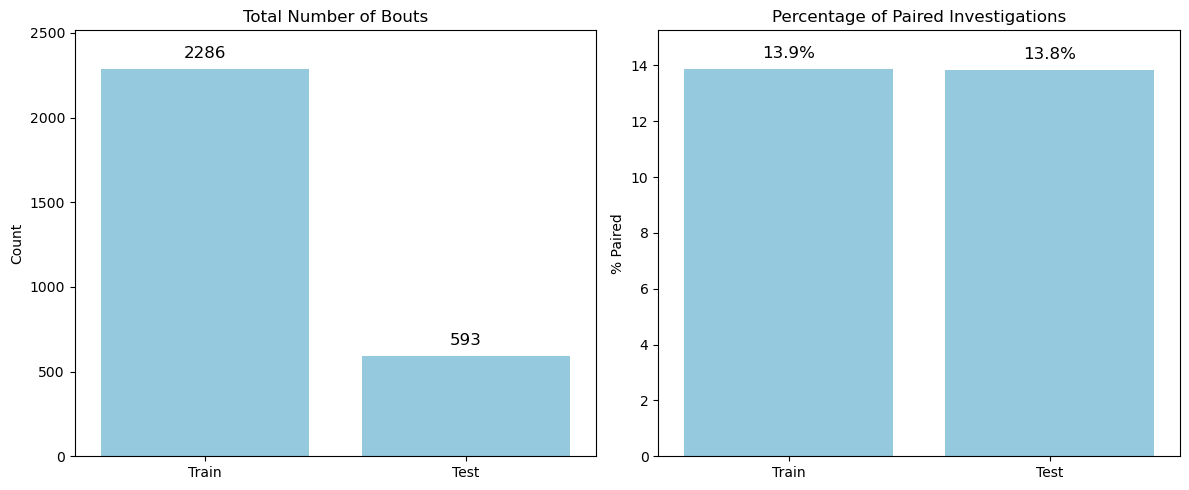

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
n_train = len(df_train)
n_test = len(df_test)

train_paired = df_train['paired'].sum()
test_paired = df_test['paired'].sum()

train_paired_pct = train_paired / n_train * 100
test_paired_pct = test_paired / n_test * 100

# --- Plot ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
colors = ['skyblue', 'skyblue']

# 1. Total number of bouts
bouts_vals = [n_train, n_test]
sns.barplot(x=['Train', 'Test'], y=bouts_vals, palette=colors, ax=ax[0])
ax[0].set_title('Total Number of Bouts')
ax[0].set_ylabel('Count')

# Add value labels and adjust y-limit
max_bouts = max(bouts_vals)
for i, val in enumerate(bouts_vals):
    ax[0].text(i, val + max_bouts * 0.02, f'{val}', ha='center', va='bottom', fontsize=12)
ax[0].set_ylim(0, max_bouts * 1.10)

# 2. Percentage of paired investigations
paired_pct_vals = [train_paired_pct, test_paired_pct]
sns.barplot(x=['Train', 'Test'], y=paired_pct_vals, palette=colors, ax=ax[1])
ax[1].set_title('Percentage of Paired Investigations')
ax[1].set_ylabel('% Paired')

max_pct = max(paired_pct_vals)
for i, val in enumerate(paired_pct_vals):
    ax[1].text(i, val + max_pct * 0.02, f'{val:.1f}%', ha='center', va='bottom', fontsize=12)
ax[1].set_ylim(0, max_pct * 1.10)

plt.tight_layout()
plt.show()


### Step 3: Apply logistic regression

In [72]:
#before applying the model, drop the investigation_ID and sequence_code
non_related = ['investigation_ID', 'sequence_code']
x_train_scaled_final = x_train_scaled.copy(deep=True)
x_test_scaled_final = x_test_scaled.copy(deep=True)
x_train_scaled_final = x_train_scaled_final.drop(columns = non_related)
x_test_scaled_final = x_test_scaled_final.drop(columns = non_related)

In [74]:
#apply the logistic regression
# Logistic Regression with GridSearchCV
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Inverse of regularization strength
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # Suitable for L2, saga for l1
    'max_iter': [1000]
}

logreg = LogisticRegression()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) #use this to preserve the percentages of paired or not paired samples are comparable

grid_search = GridSearchCV(logreg, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(x_train_scaled_final, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'C': 166.81005372000558, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


### Step 4: Evaluate the model


Test Accuracy: 0.8786
F1 Score: 0.2340
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93       511
           1       0.92      0.13      0.23        82

    accuracy                           0.88       593
   macro avg       0.90      0.57      0.58       593
weighted avg       0.88      0.88      0.84       593



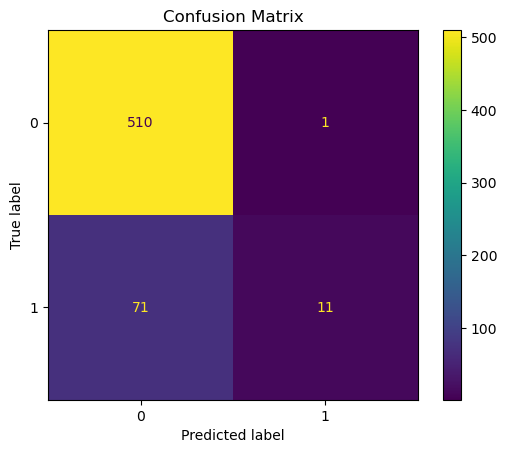

In [75]:
# Predict on test set
y_pred = best_model.predict(x_test_scaled_final)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Full report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, x_test_scaled_final, y_test)
plt.title("Confusion Matrix")
plt.show()


C:\Users\sky\AppData\Local\Temp\ipykernel_20340\2324027629.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=coef_df, palette='vlag')


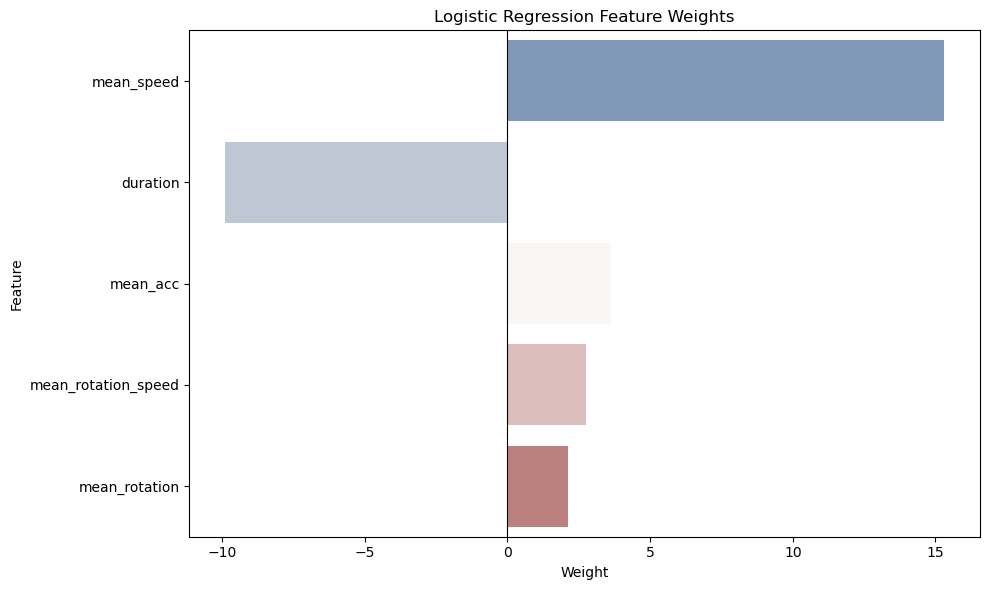

In [76]:
#visualize the coefficient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names
feature_names = x_train_scaled_final.columns

# Get model coefficients (for binary classification, this is 1D)
coefs = best_model.coef_[0]

# Create a DataFrame for better plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': coefs
}).sort_values(by='Weight', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=coef_df, palette='vlag')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Logistic Regression Feature Weights')
plt.tight_layout()
plt.show()
